In [ ]:
using PhotonPropagation
using NeutrinoTelescopes
using PhysicsTools
using StaticArrays
using LinearAlgebra
using Random
using Flux
using BSON: @load
using DataFrames
using CairoMakie
using Glob

In [6]:
workdir = ENV["ECAPSTOR"]

model = gpu(PhotonSurrogate(
    joinpath(workdir, "snakemake/time_surrogate_perturb/extended/amplitude_2_FNL.bson"),
    joinpath(workdir, "snakemake/time_surrogate_perturb/extended/time_uncert_0_2_FNL.bson")
))


medium = make_cascadia_medium_properties(0.95)
rng = MersenneTwister(31338)


feat_buffer = create_input_buffer(model, 16, 1)
device = cpu
target = POM(SA_F32[0., 0., 0.], 1);

In [19]:
function plot_pdf(settings::AbstractVector{<:NamedTuple}, variable::String, variable_range::AbstractVector)
    fig = Figure()
    ax = Axis(
        fig[1, 1],
        xlabel="Time Residual (ns)",
        ylabel="Hits / time",
        )
    input = @view feat_buffer[:, 1:16]

    times = -10:0.1:100

    for setting in settings

        # tgeo = calc_tgeo(setting.particle, setting.target, medium)
        log_expec_per_pmt, log_expec_per_src_pmt_rs = get_log_amplitudes(
            [setting.particle],
            [setting.target],
             setting.model;
             feat_buffer=feat_buffer,
             device=device,
             abs_scale=setting.abs_scale,
             sca_scale=setting.sca_scale)
        
        create_model_input!(
            setting.model.time_model,
            [setting.particle],
            [setting.target],
            feat_buffer,
            abs_scale=setting.abs_scale,
            sca_scale=setting.sca_scale)
        flow_params = cpu(setting.model.time_model.embedding(device(input)))

        pdf_eval = eval_transformed_normal_logpdf(
                            times,
                            flow_params[:, setting.pmt_ix],
                            setting.model.time_model.range_min,
                            setting.model.time_model.range_max
                        )

        lines!(ax, times, exp.(pdf_eval .+ log_expec_per_pmt[setting.pmt_ix, 1, 1]), color=setting.color_val,
              colormap=:viridis, colorrange=extrema(variable_range))
    end

    Colorbar(
        fig[2, 1],
        limits = extrema(variable_range),
        size = 25,
        colormap = cgrad(:viridis, length(settings), categorical = true),
        vertical = false,
        label=variable)

    return fig
end


function plot_pdf_grid(settings::AbstractVector{<:NamedTuple}, variable::String, variable_range::AbstractVector)
    fig = Figure(size=(1000, 700))
    input = @view feat_buffer[:, 1:16]
    times = -10:0.1:100

    gl = GridLayout()
    fig[1, 1] = gl
    for pmt_ix in 1:16

        row, col = divrem(pmt_ix-1, 4)
        row +=1
        col +=1

        ax = Axis(
            gl[row, col],
            xlabel="Time Residual (ns)",
            ylabel="Hits / time",
            )
        
        for setting in settings

            # tgeo = calc_tgeo(setting.particle, setting.target, medium)
            log_expec_per_pmt, log_expec_per_src_pmt_rs = get_log_amplitudes(
                [setting.particle],
                [setting.target],
                setting.model;
                feat_buffer=feat_buffer,
                device=device,
                abs_scale=setting.abs_scale,
                sca_scale=setting.sca_scale)
            
            create_model_input!(
                setting.model.time_model,
                [setting.particle],
                [setting.target],
                feat_buffer,
                abs_scale=setting.abs_scale,
                sca_scale=setting.sca_scale)
            flow_params = cpu(setting.model.time_model.embedding(device(input)))

            pdf_eval = eval_transformed_normal_logpdf(
                                times,
                                flow_params[:, pmt_ix],
                                setting.model.time_model.range_min,
                                setting.model.time_model.range_max
                            )

            lines!(ax, times, exp.(pdf_eval .+ log_expec_per_pmt[pmt_ix, 1, 1]), color=setting.color_val,
                colormap=:viridis, colorrange=extrema(variable_range))
        end
    end
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    Colorbar(
        fig[2, 1],
        limits = extrema(variable_range),
        size = 25,
        colormap = cgrad(:viridis, length(settings), categorical = true),
        vertical = false,
        label=variable)

    return fig
end

plot_pdf_grid (generic function with 1 method)

## Absorption Scale Variation


In [10]:
particle_pos = SA[-15.0, 0., 5.]
particle_dir = sph_to_cart(0.7, 0.3)
particle_energy = 7e4

70000.0

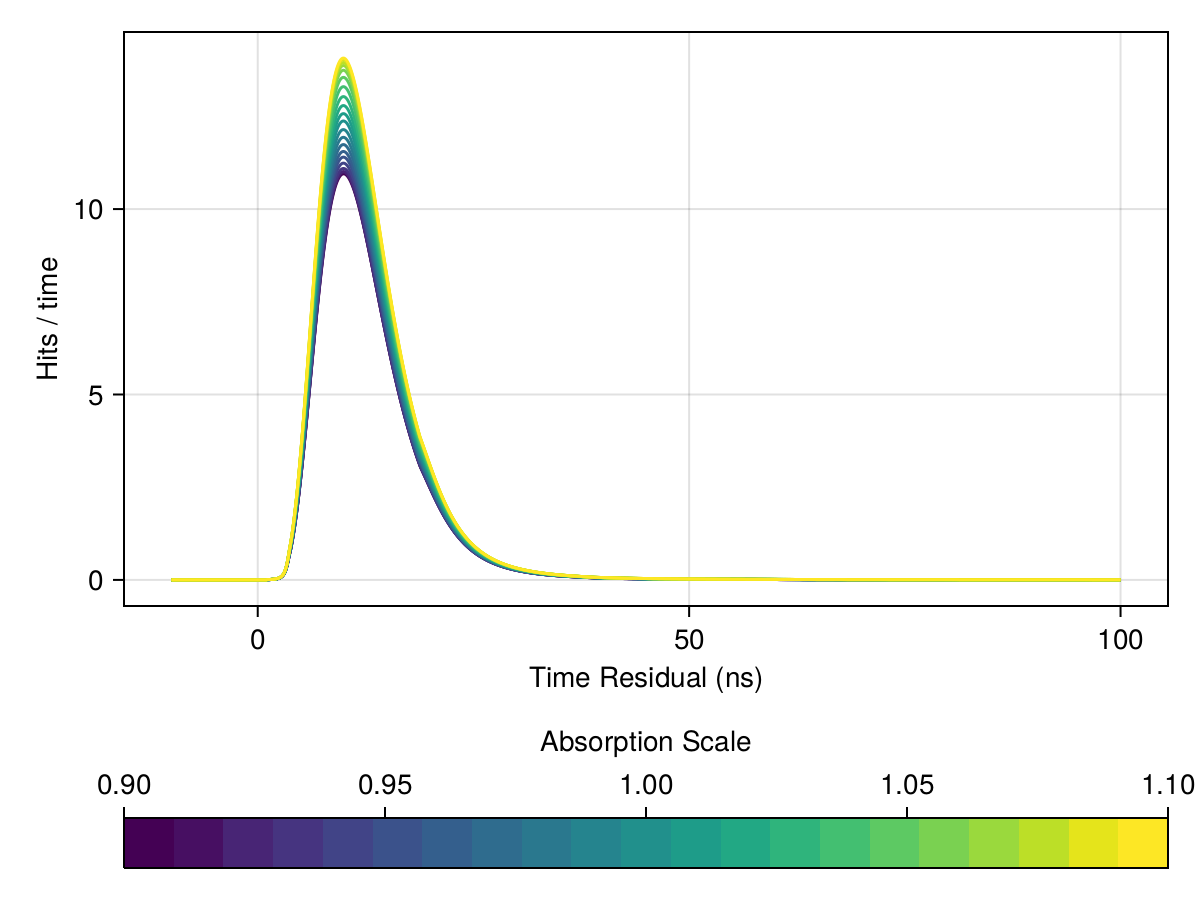

In [20]:
abs_scales = 0.9:0.01:1.1
settings = NamedTuple[]
for abs_scale in abs_scales
    setting = (
        particle = Particle(particle_pos, particle_dir, 0.0, particle_energy, 0.0, PEMinus),
        target = target,
        abs_scale = abs_scale,
        sca_scale = 1.,
        model = model,
        pmt_ix = 16,
        color_val = abs_scale,
    )
    push!(settings, setting)
end
plot_pdf(settings, "Absorption Scale", abs_scales)

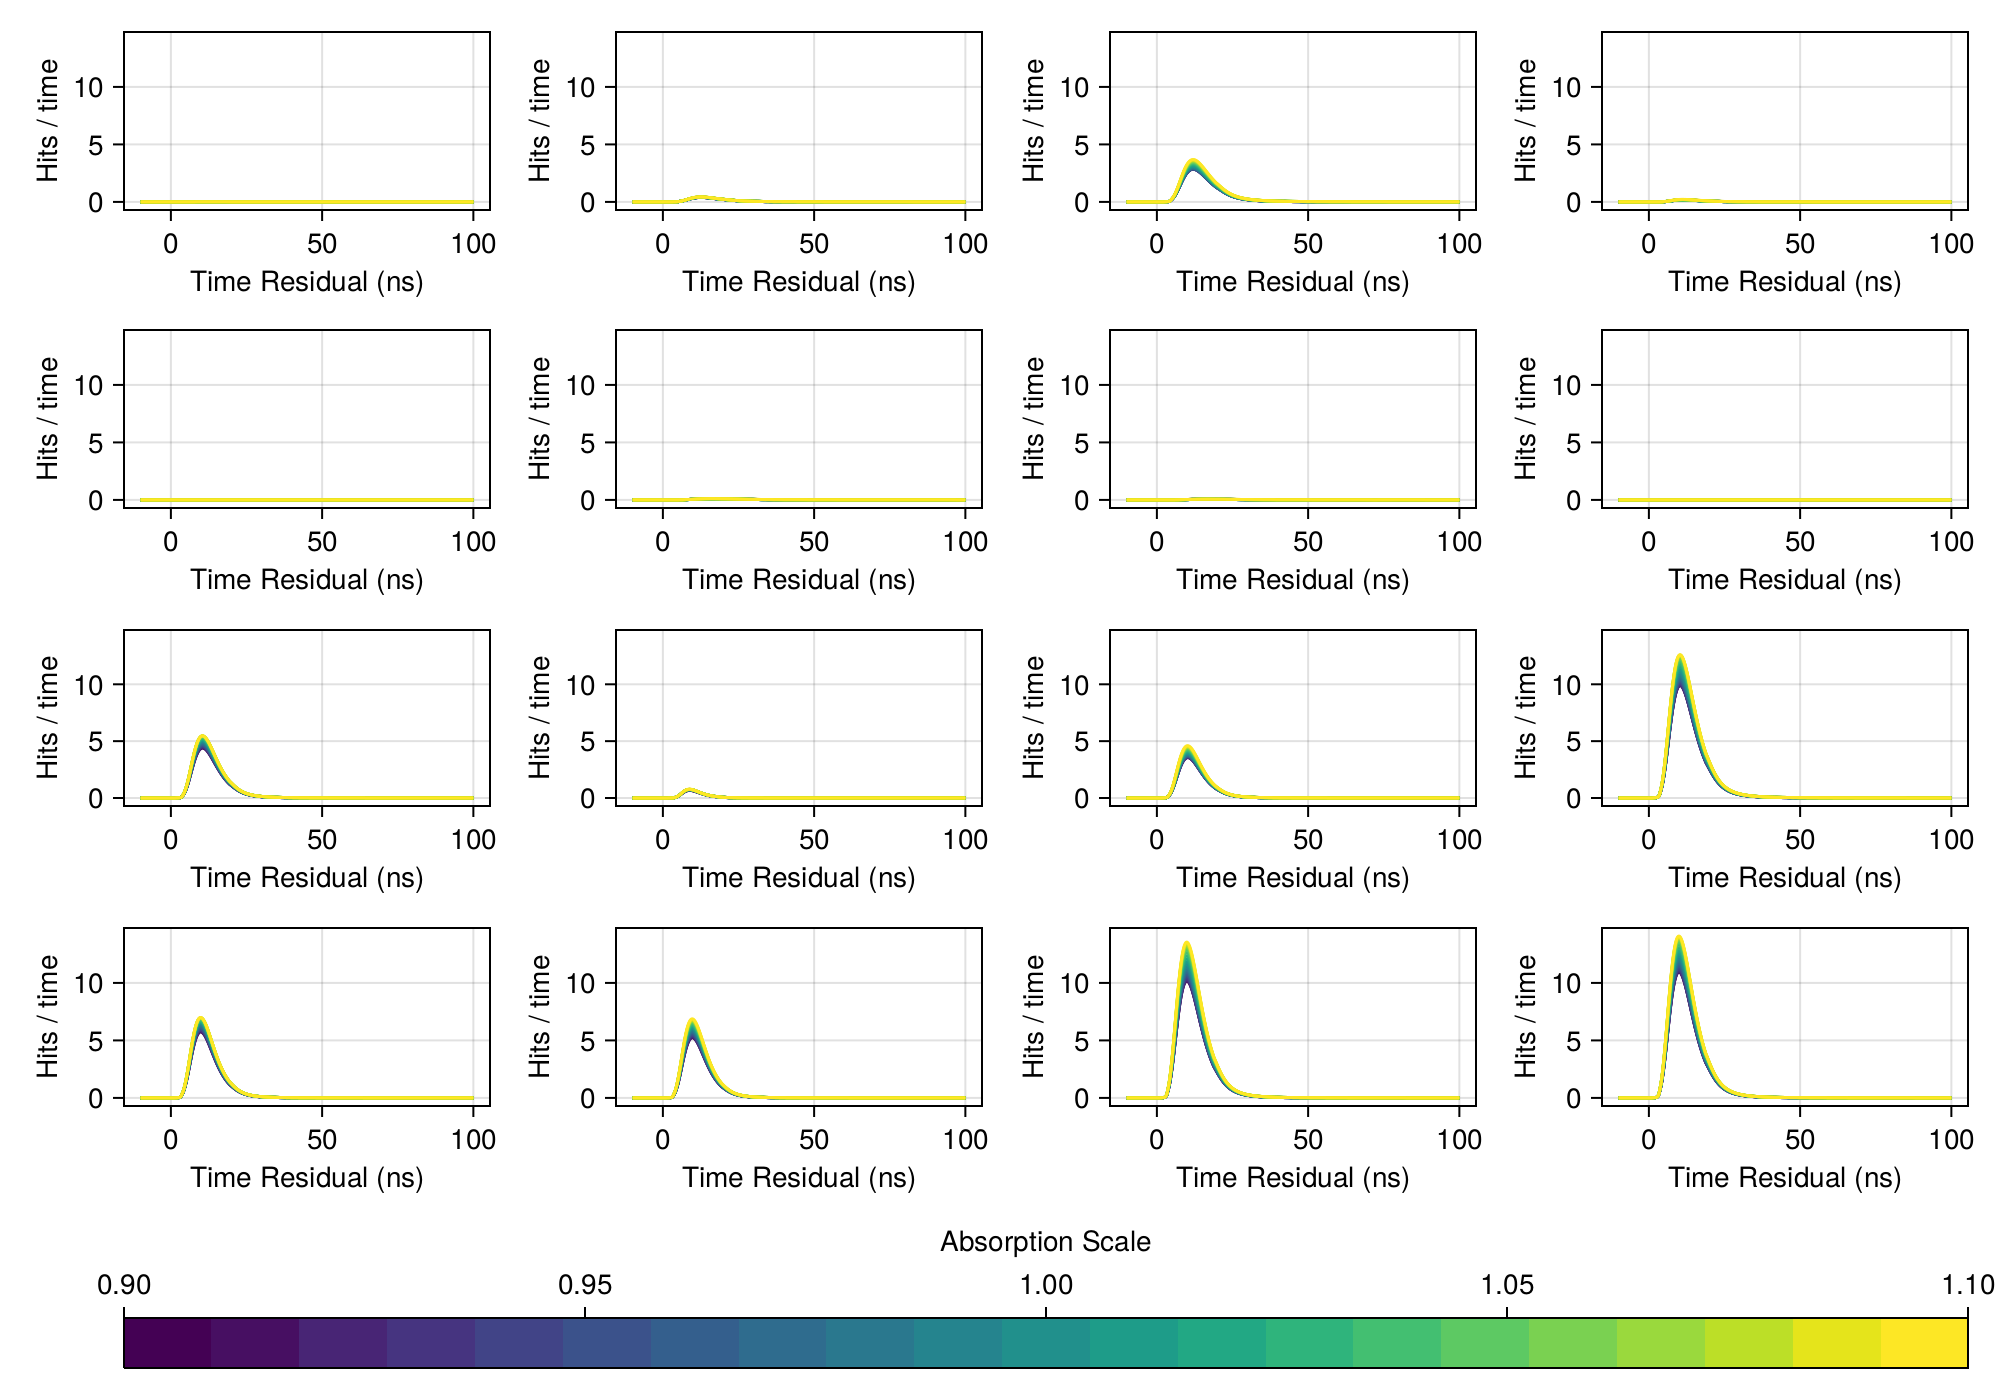

In [12]:
plot_pdf_grid(settings, "Absorption Scale", abs_scales)

## Scattering Scale Variation

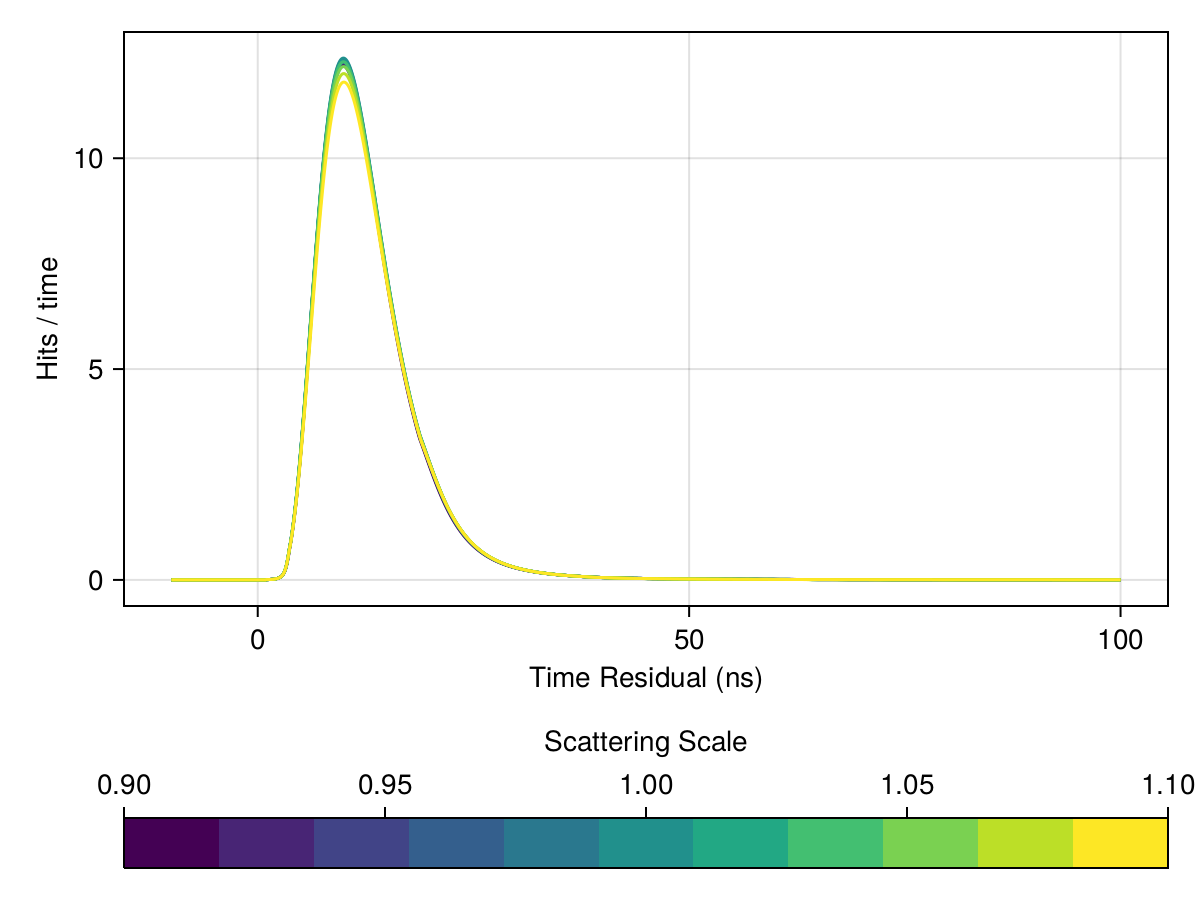

In [22]:
sca_scales = 0.9:0.02:1.1
settings = NamedTuple[]
for sca_scale in sca_scales
    setting = (
        particle = Particle(particle_pos, particle_dir, 0.0, particle_energy, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = sca_scale,
        model = model,
        pmt_ix = 16,
        color_val = sca_scale,
    )
    push!(settings, setting)
end
plot_pdf(settings, "Scattering Scale", sca_scales)




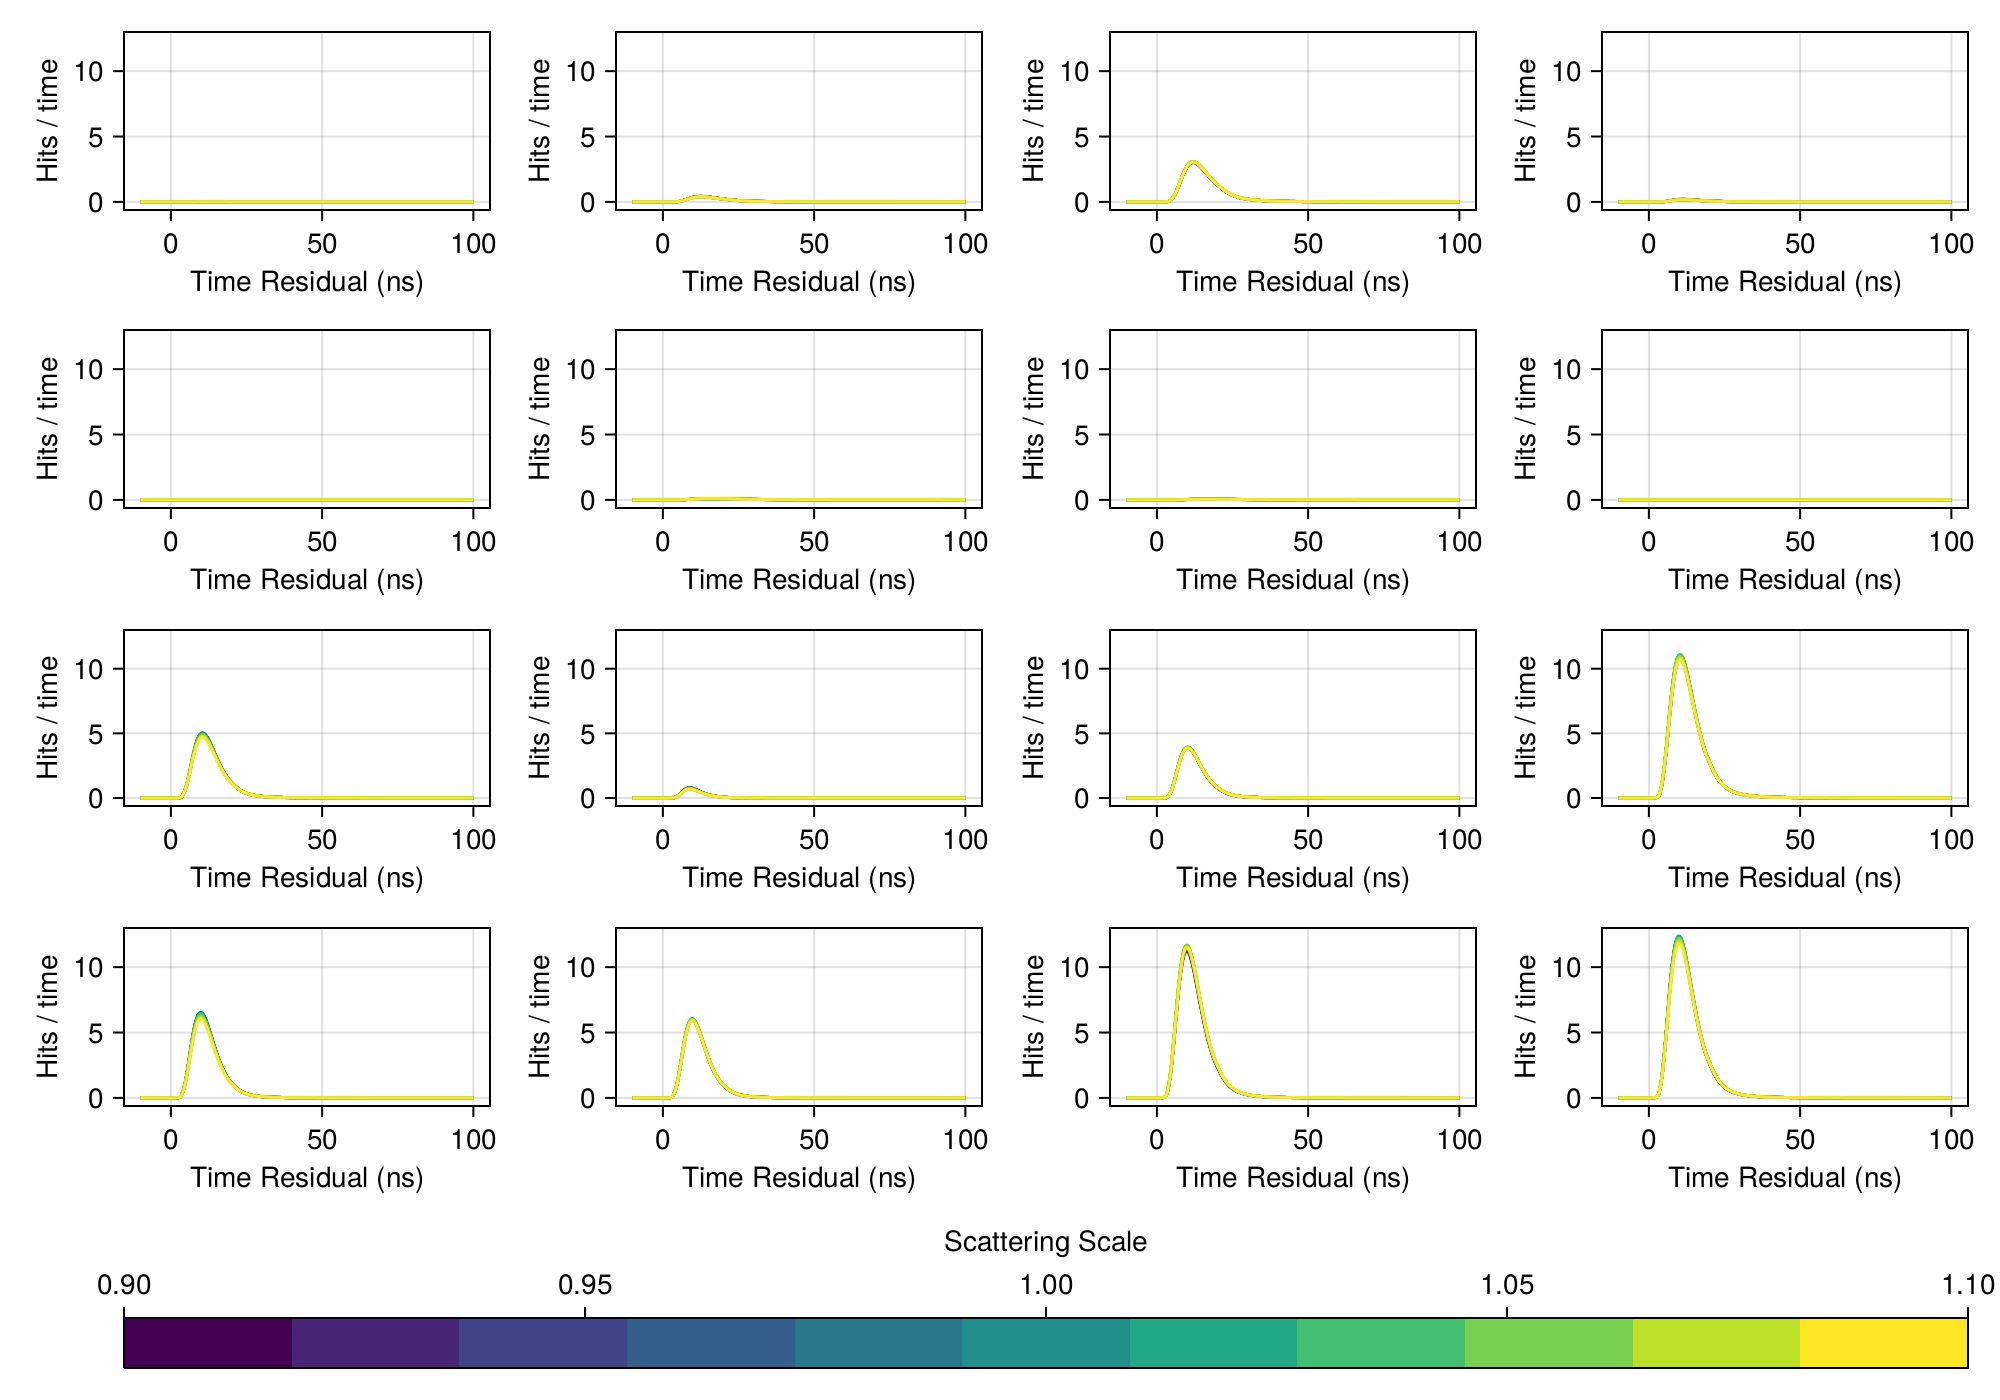

In [23]:
plot_pdf_grid(settings, "Scattering Scale", sca_scales)

## Zenith Angle Variation

In [25]:
particle_azimuth = deg2rad(120)

2.0943951023931953

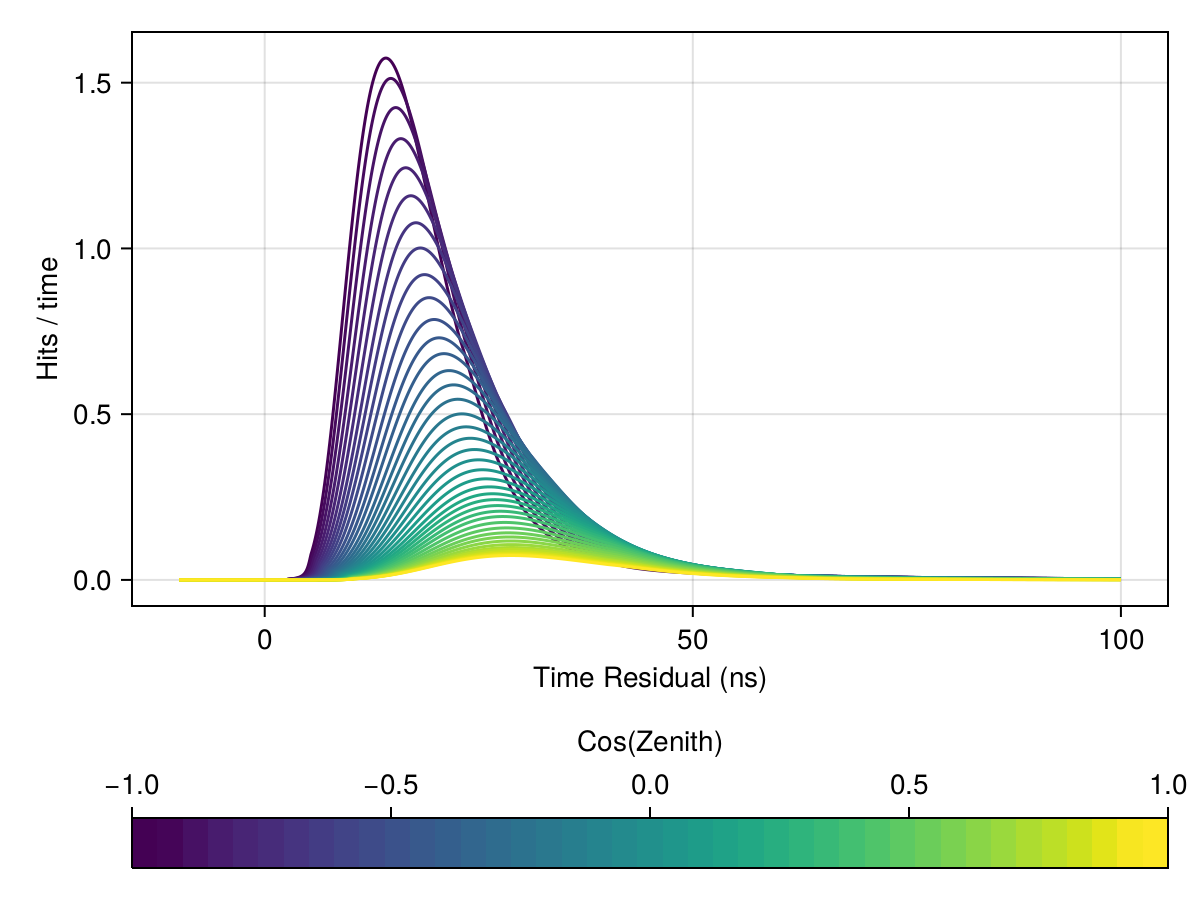

In [26]:
settings = NamedTuple[]
cos_zeniths = -1:0.05:1
for cos_zen in cos_zeniths
    setting = (
        particle = Particle(particle_pos, sph_to_cart(cos_zen, particle_azimuth), 0.0, particle_energy, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 3,
        color_val = cos_zen,
    )
    push!(settings, setting)
end
plot_pdf(settings, "Cos(Zenith)", cos_zeniths)



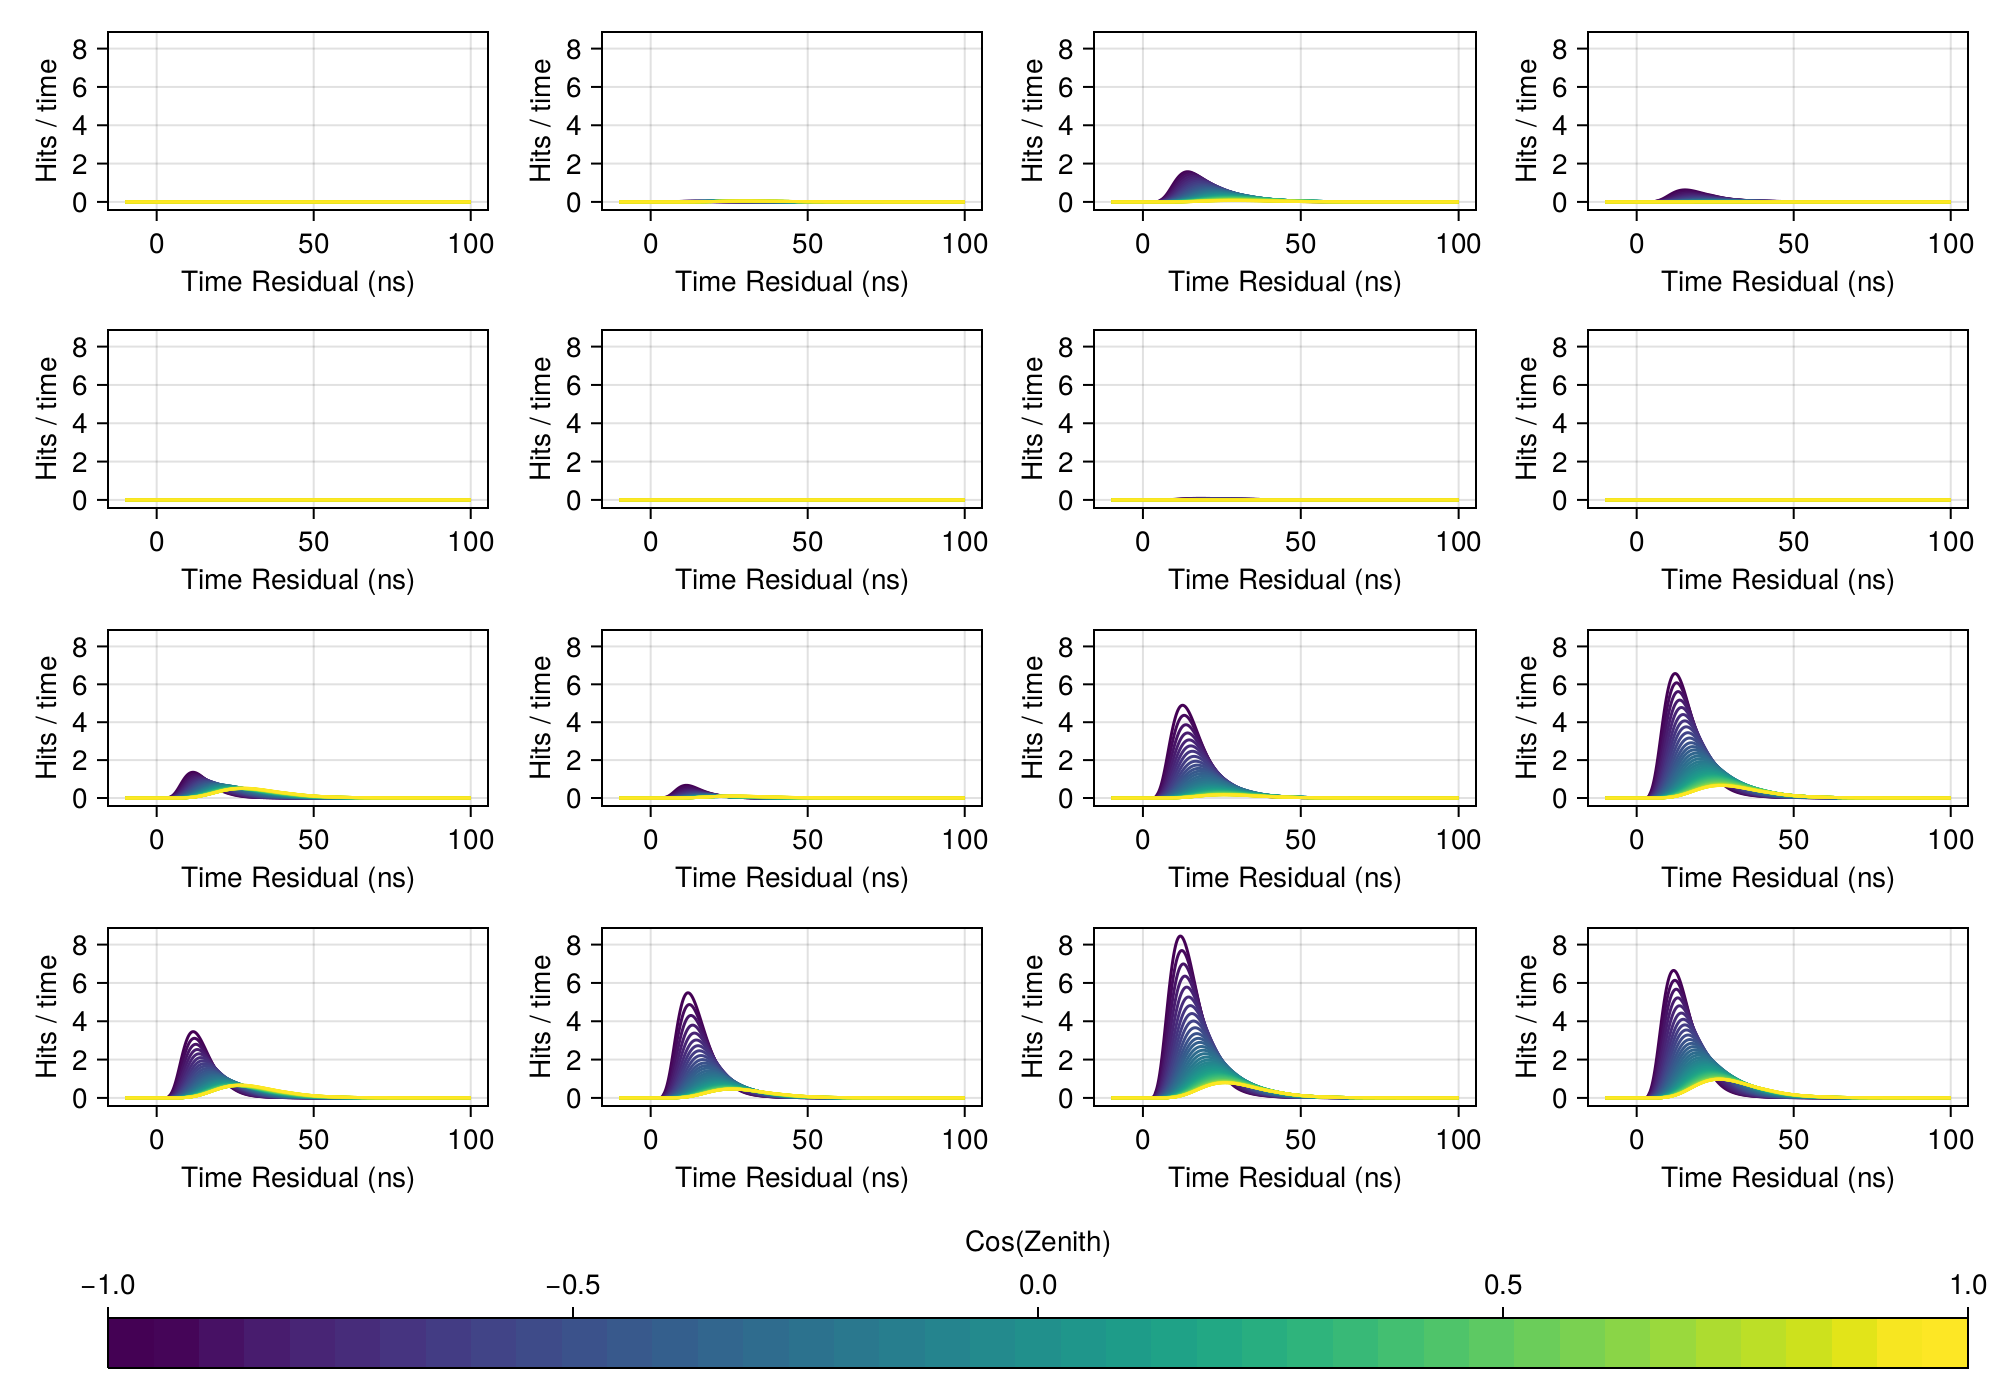

In [27]:
plot_pdf_grid(settings, "Cos(Zenith)", cos_zeniths)

## Azimuth Angle Variation

In [43]:
particle_zenith = 0.7

0.7

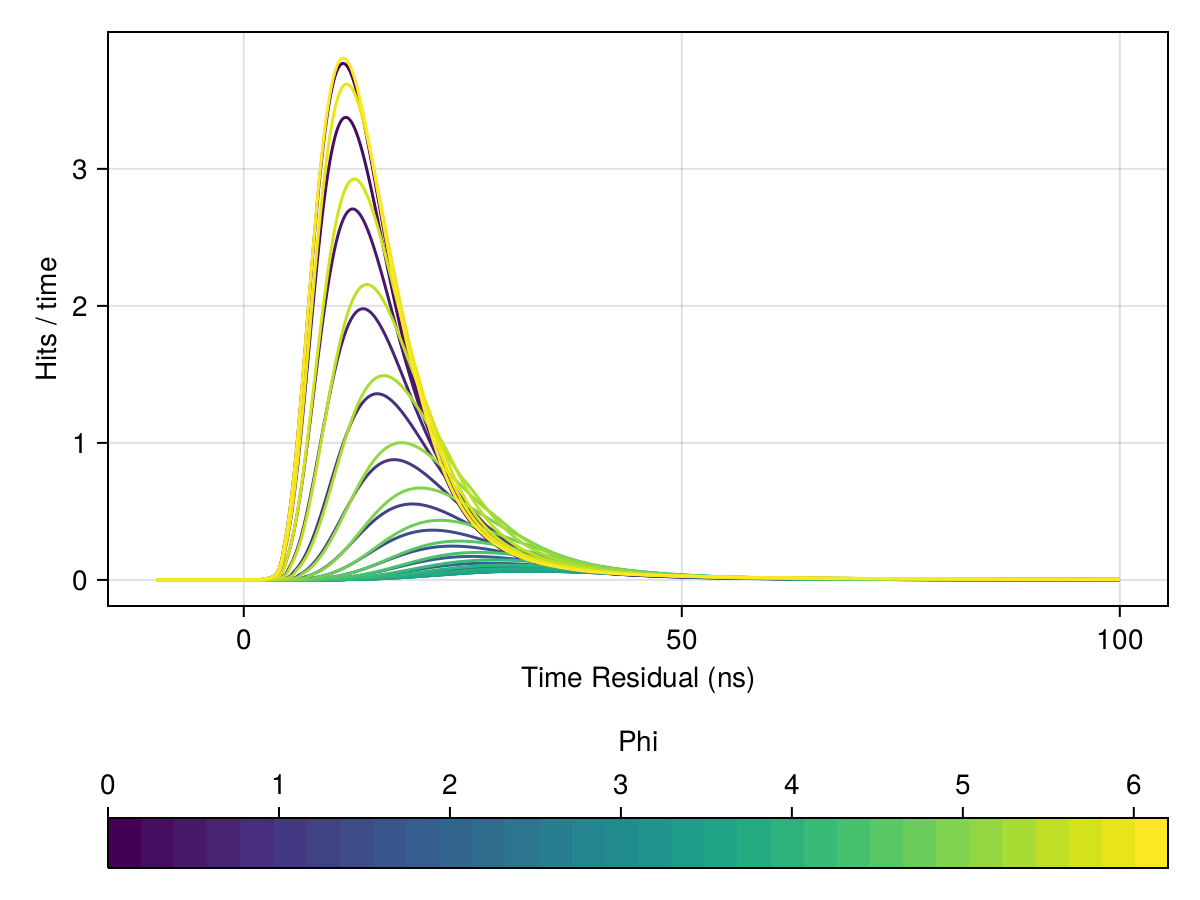

In [44]:
settings = NamedTuple[]
phis = 0:0.2:2*π
for phi in phis
    setting = (
        particle = Particle(particle_pos, sph_to_cart(particle_zenith, phi), 0.0, particle_energy, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 3,
        color_val = phi,

    )
    push!(settings, setting)
end
plot_pdf(settings, "Phi", phis)



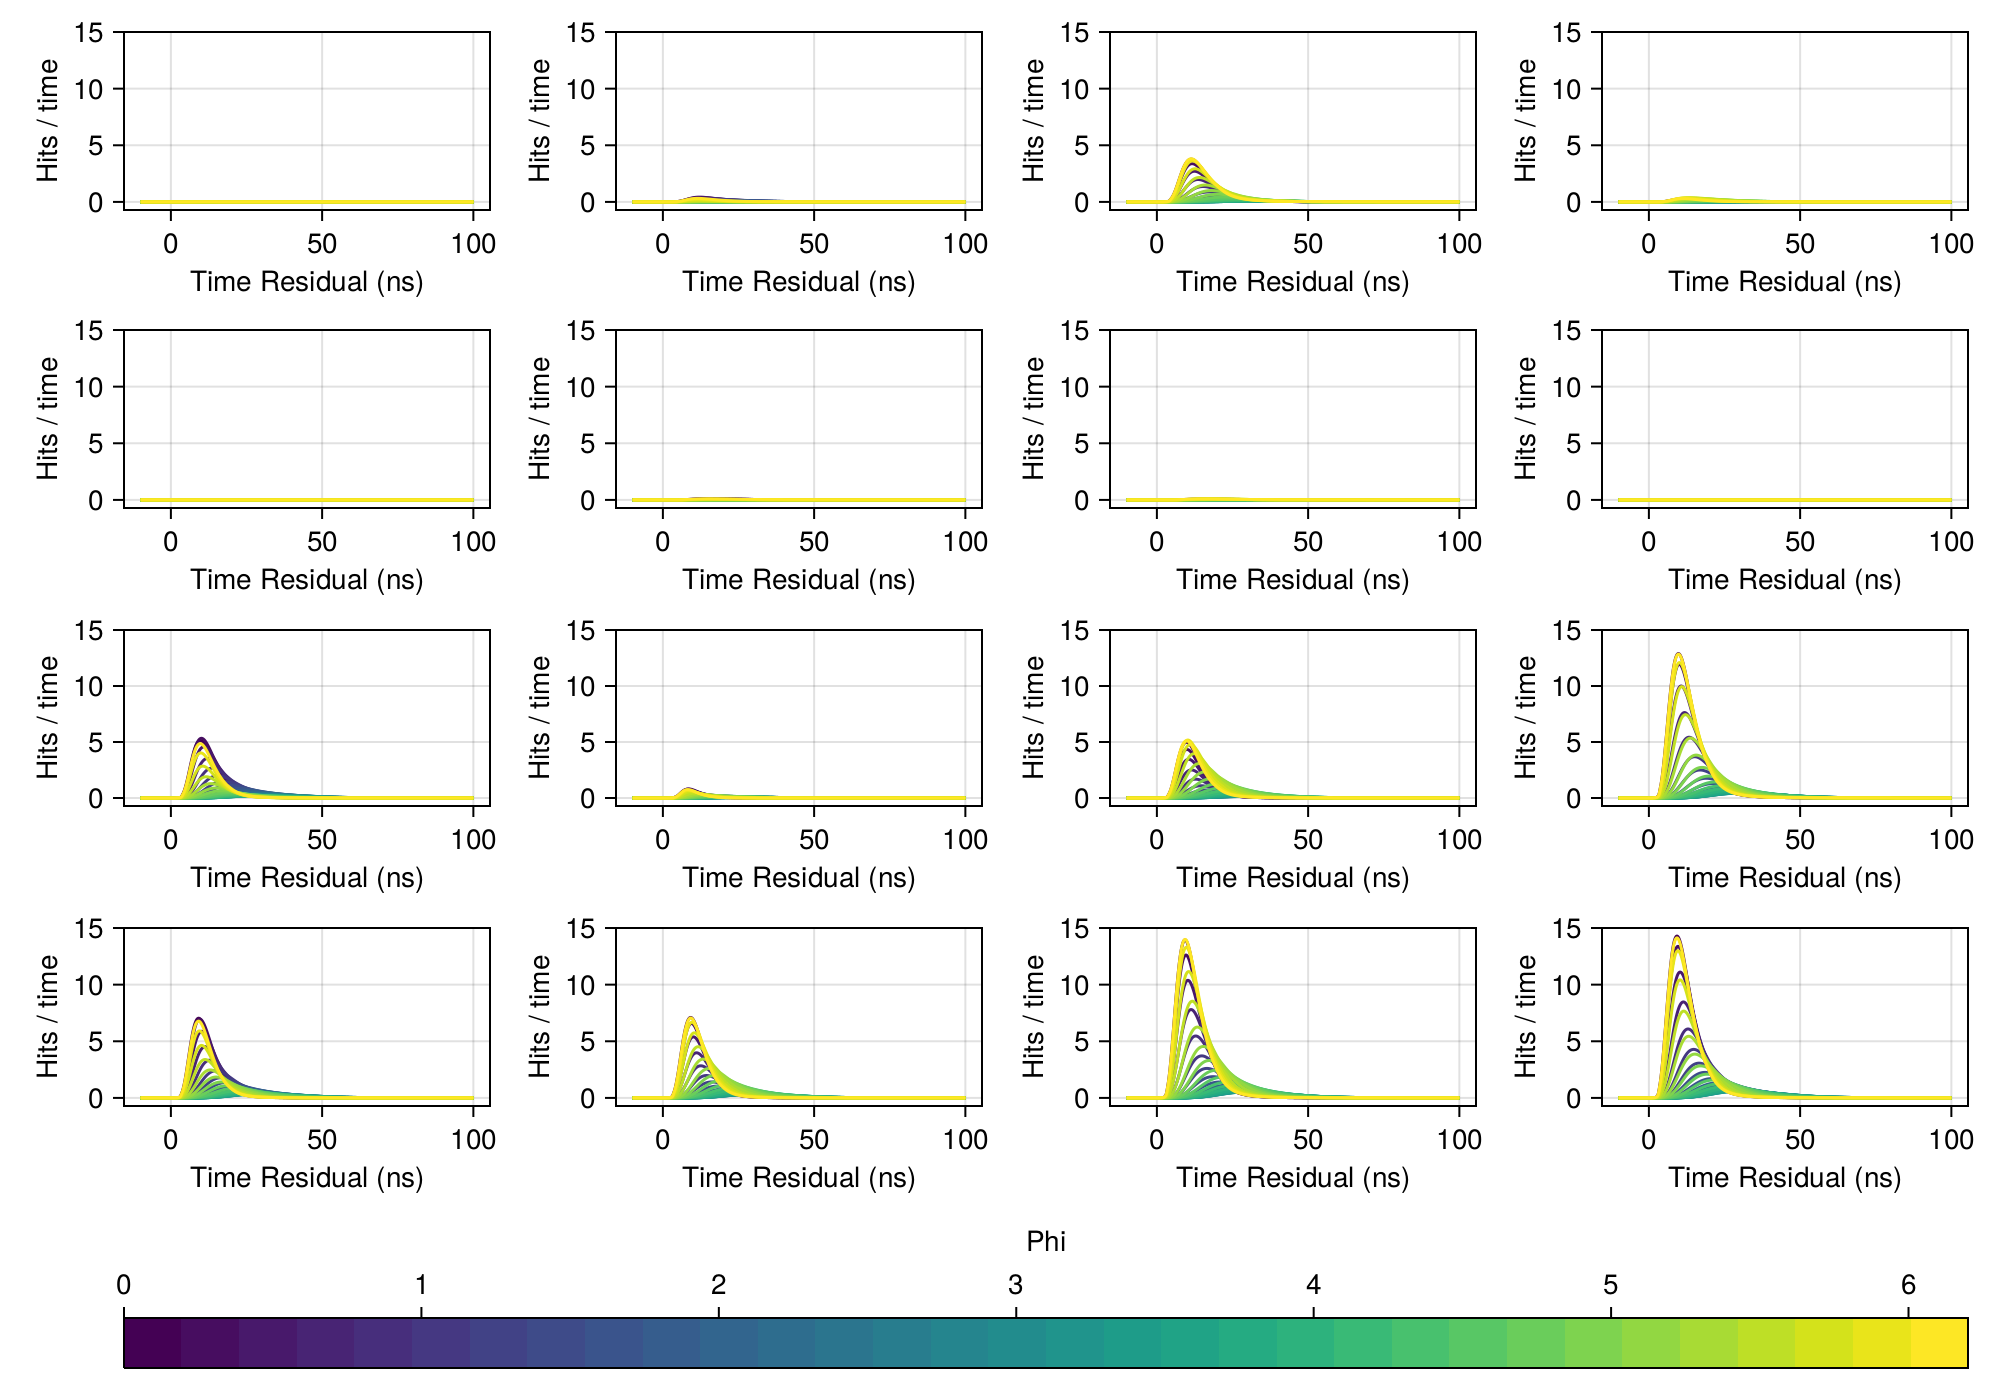

In [45]:
plot_pdf_grid(settings, "Phi", phis)

## Distance Variation

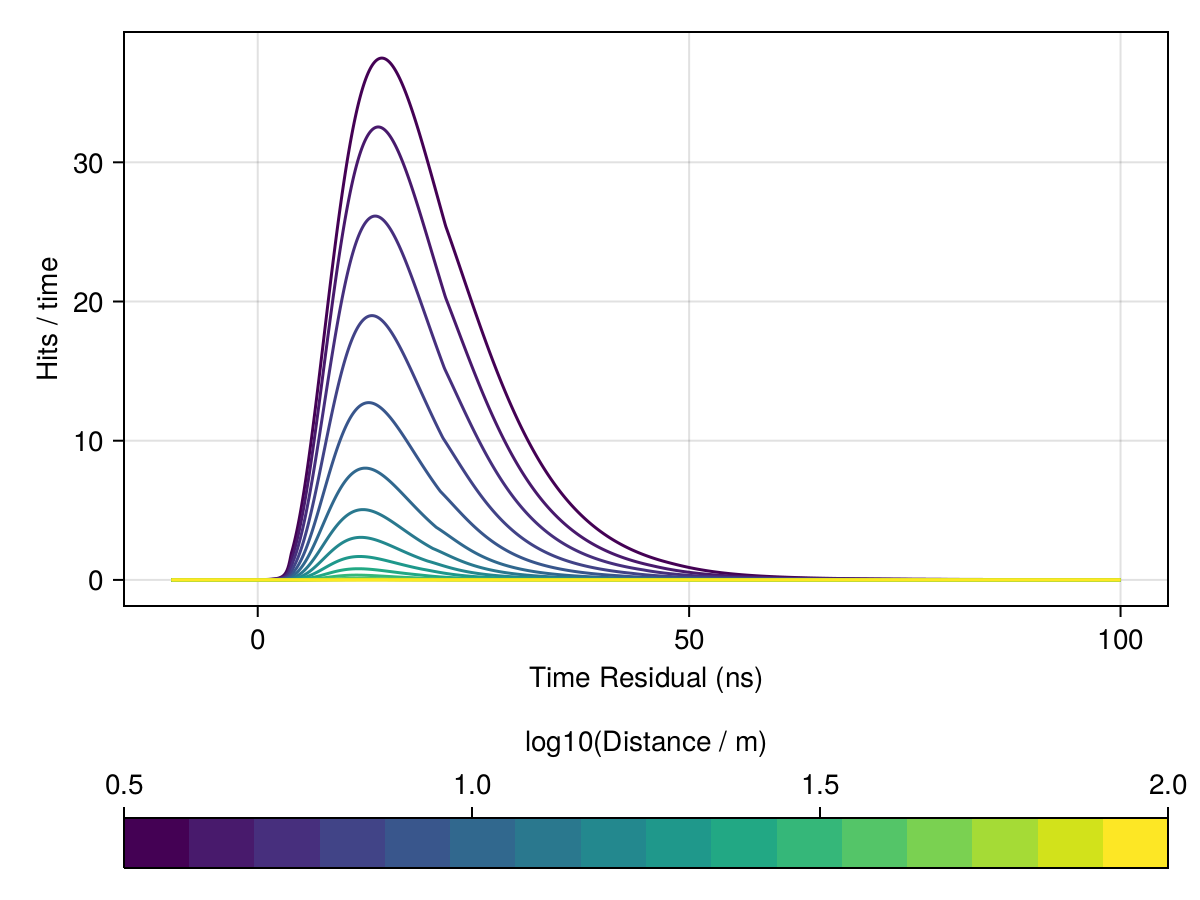

In [48]:
settings = NamedTuple[]
log_dists = 0.5:0.1:2
for logdist in log_dists

    pdir = particle_pos ./ norm(particle_pos)

    setting = (
        particle = Particle(pdir .* 10^logdist, particle_dir, 0.0, particle_energy, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 3,
        color_val = logdist,
    )
    push!(settings, setting)
end
plot_pdf(settings, "log10(Distance / m)", log_dists)




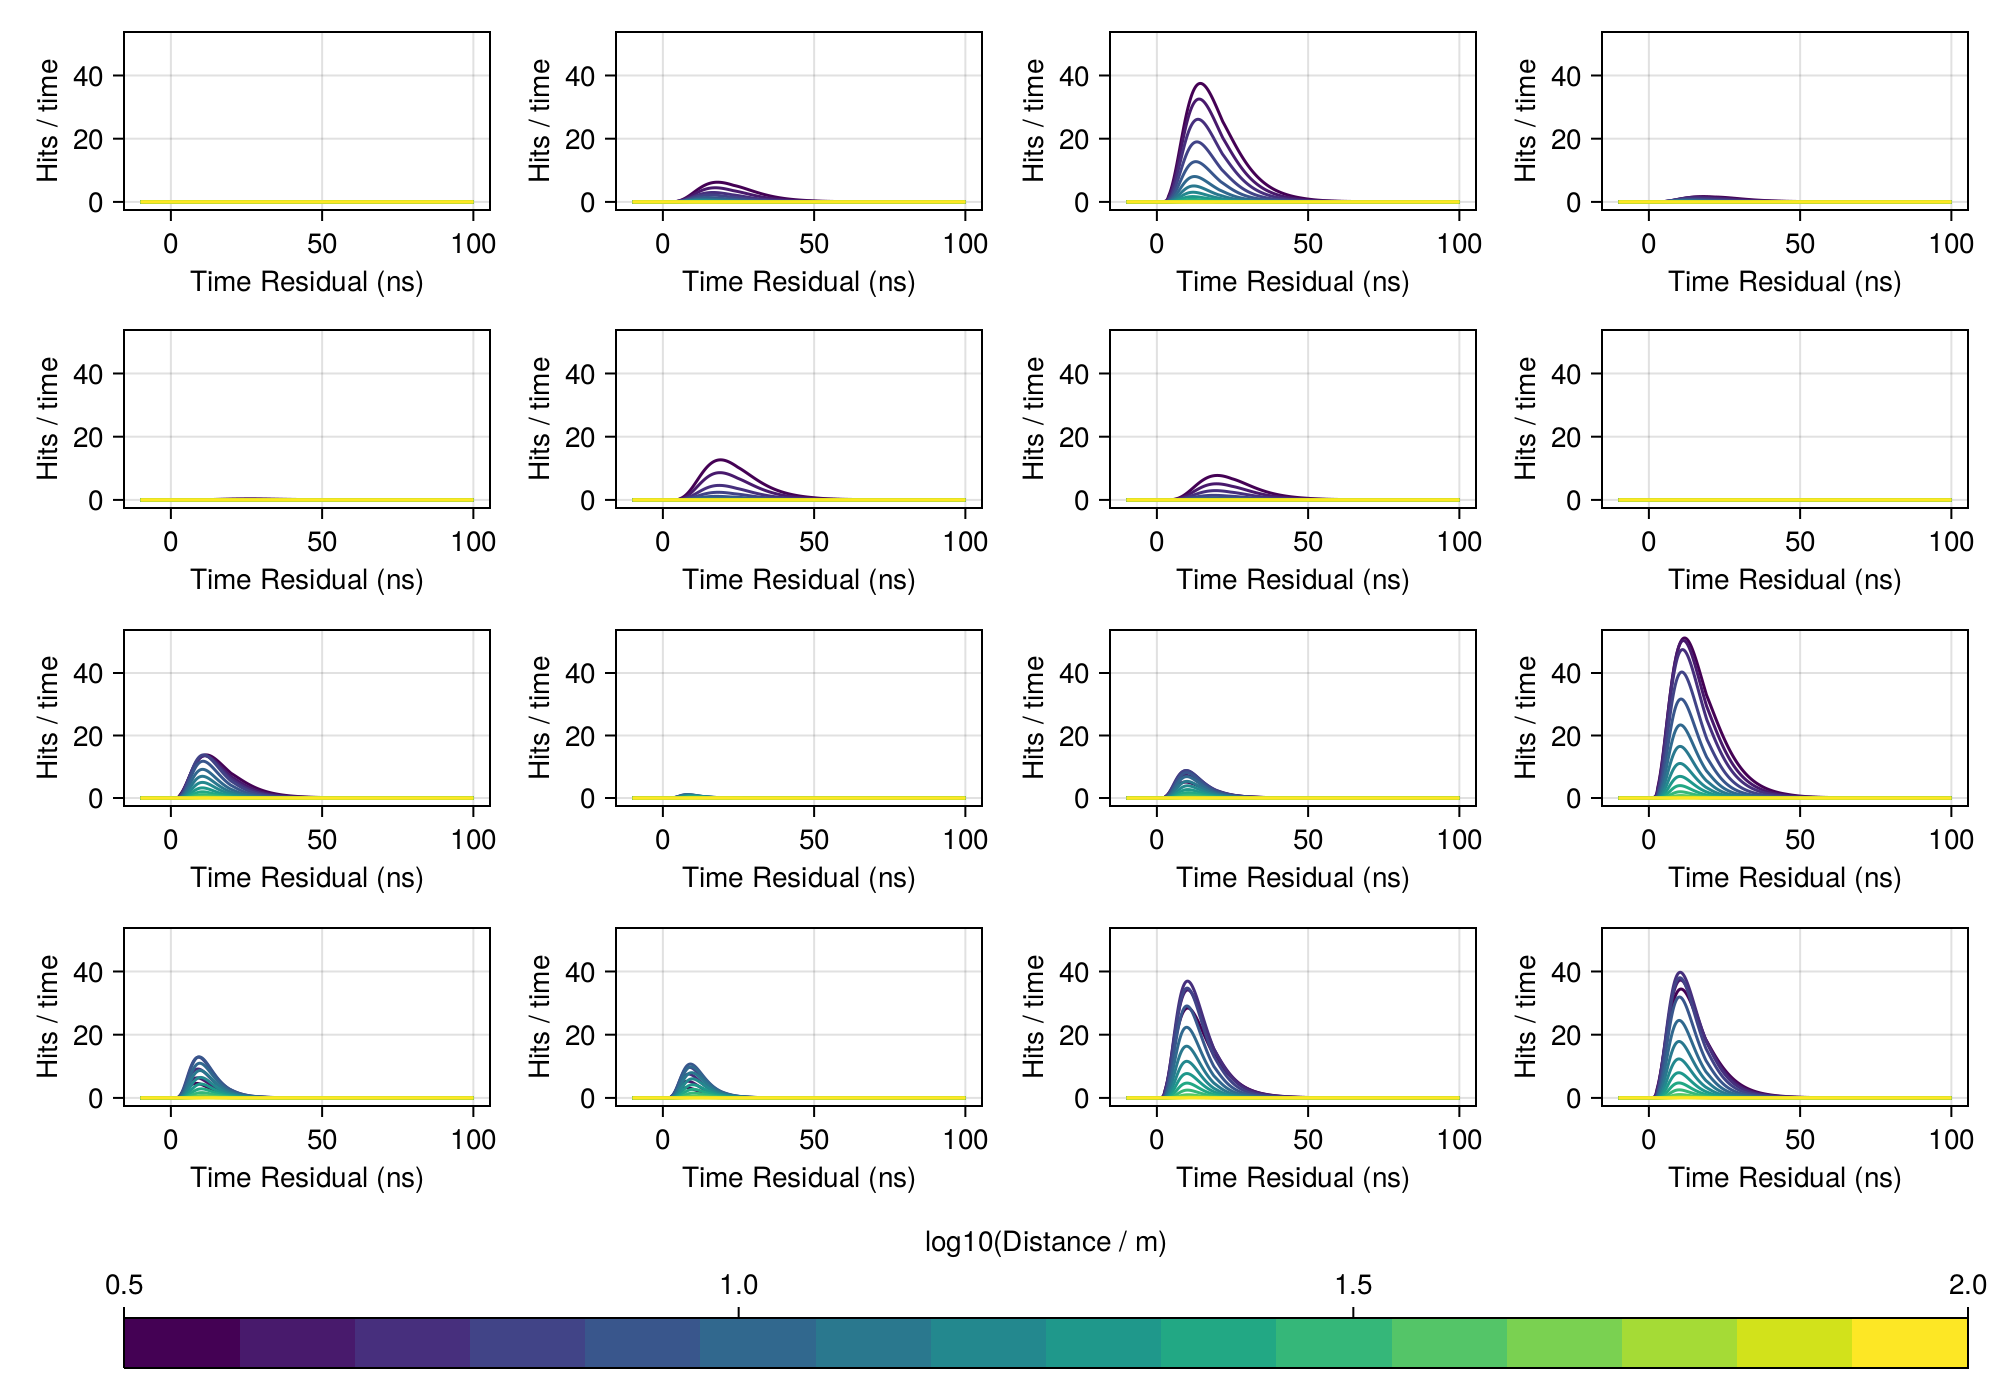

In [49]:
plot_pdf_grid(settings, "log10(Distance / m)", log_dists)

## Energy Variation

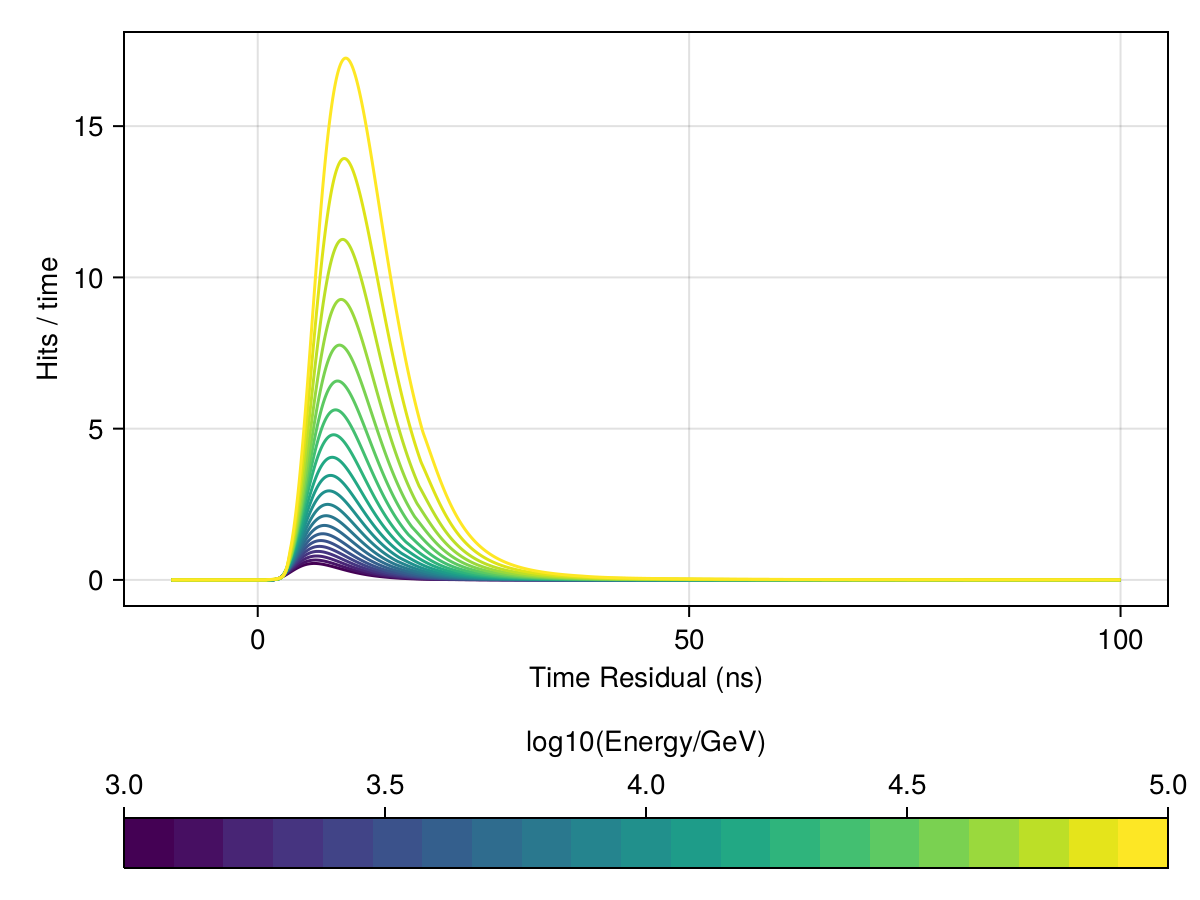

In [51]:
settings = NamedTuple[]
log10_energies = 3:0.1:5
for log10e in log10_energies
    setting = (
        particle = Particle(particle_pos, particle_dir, 0.0, 10^log10e, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 16,
        color_val = log10e
    )
    push!(settings, setting)
end
plot_pdf(settings, "log10(Energy/GeV)", log10_energies)



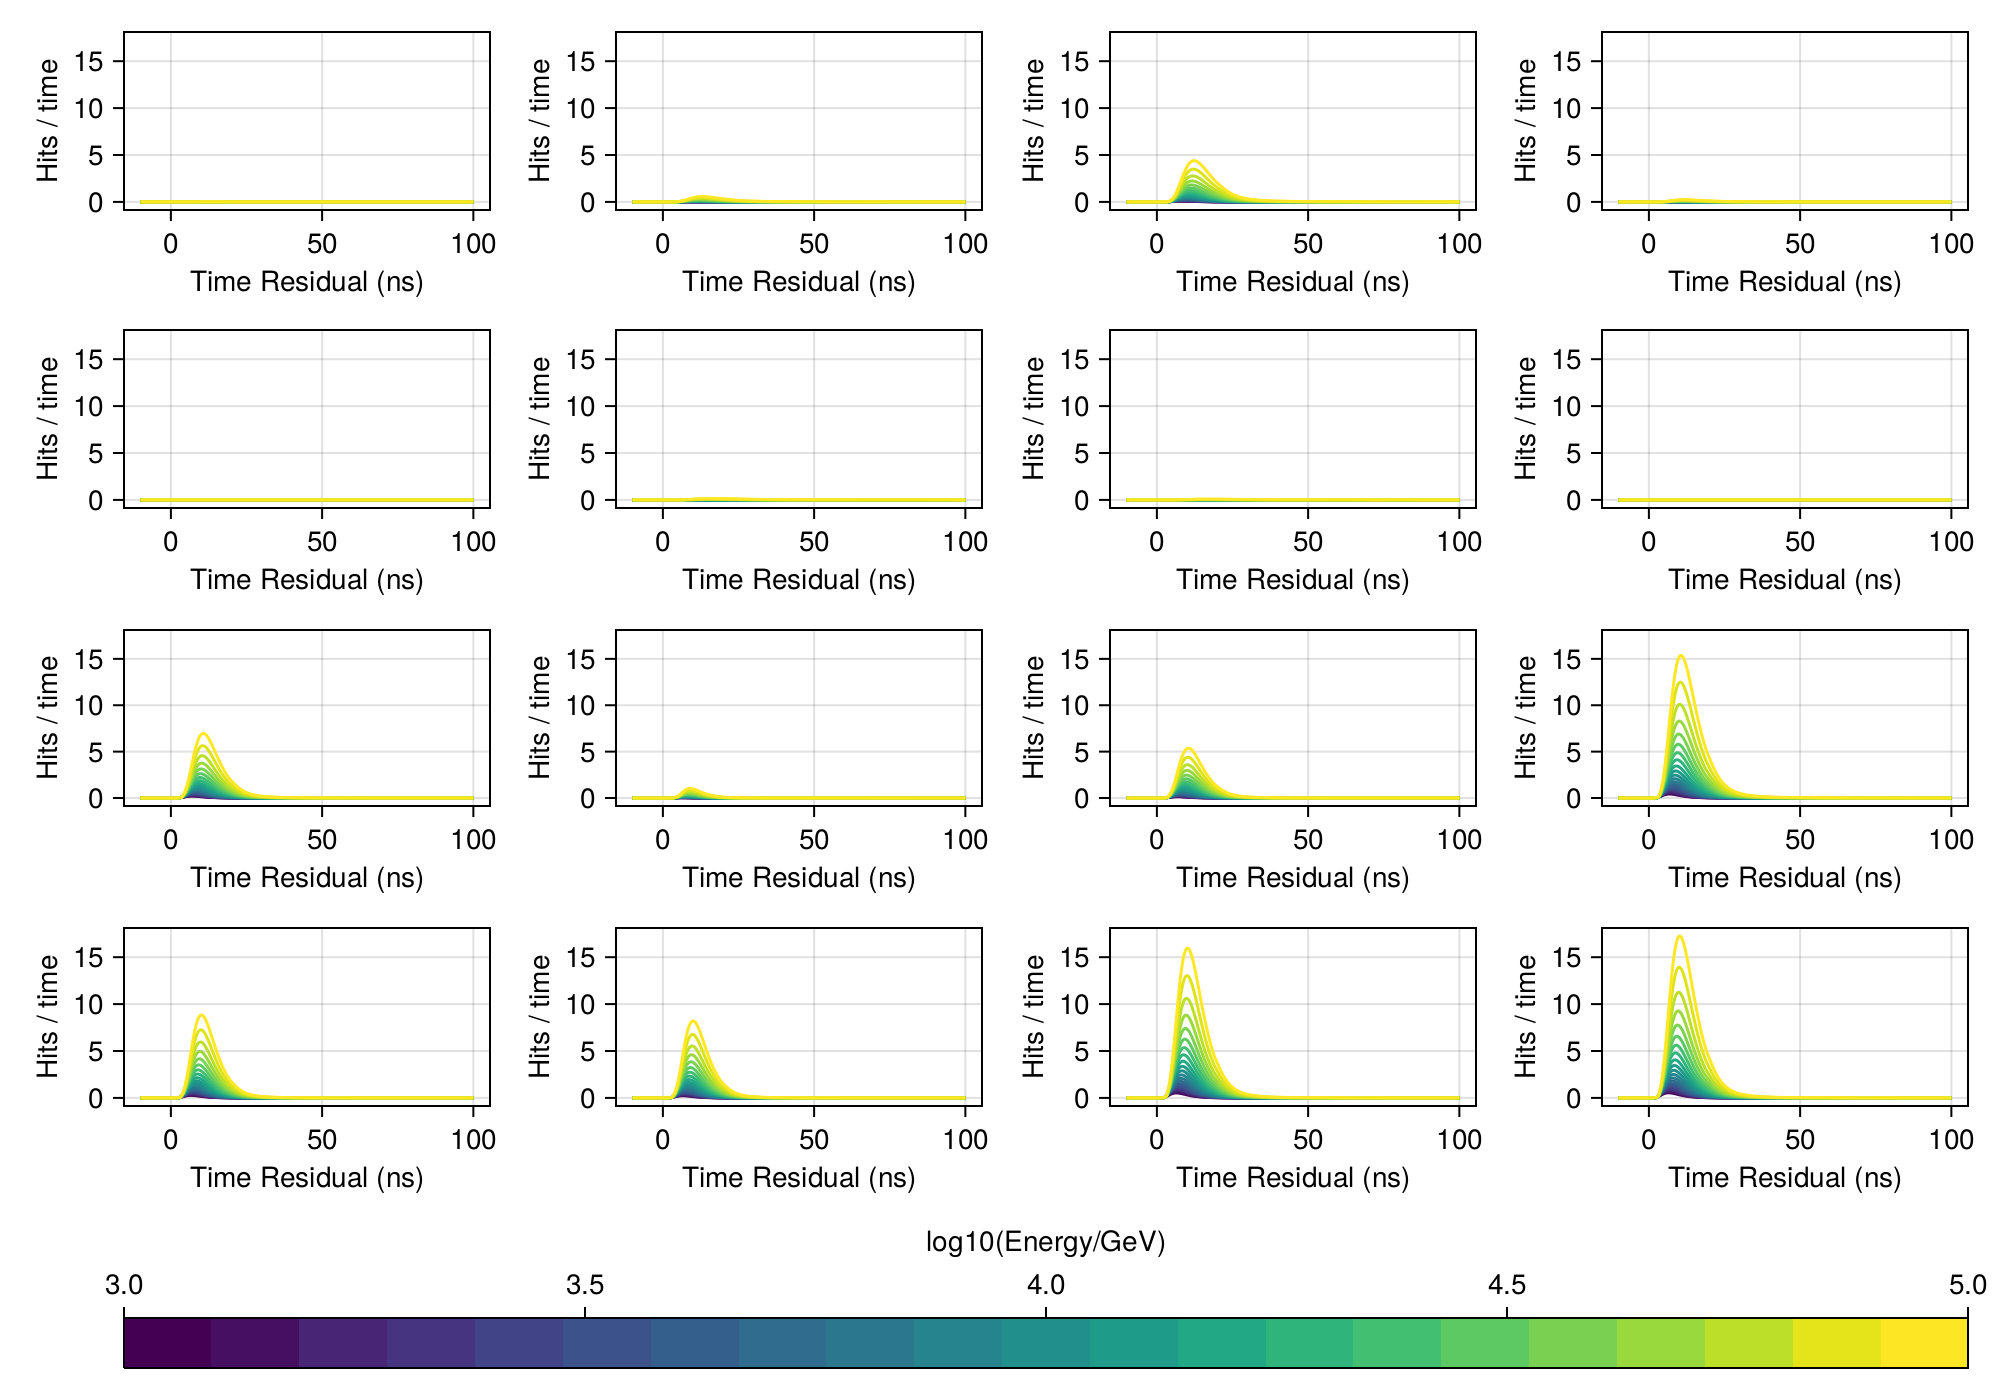

In [52]:
plot_pdf_grid(settings, "log10(Energy/GeV)", log10_energies)

## Timing Uncertainty Variation

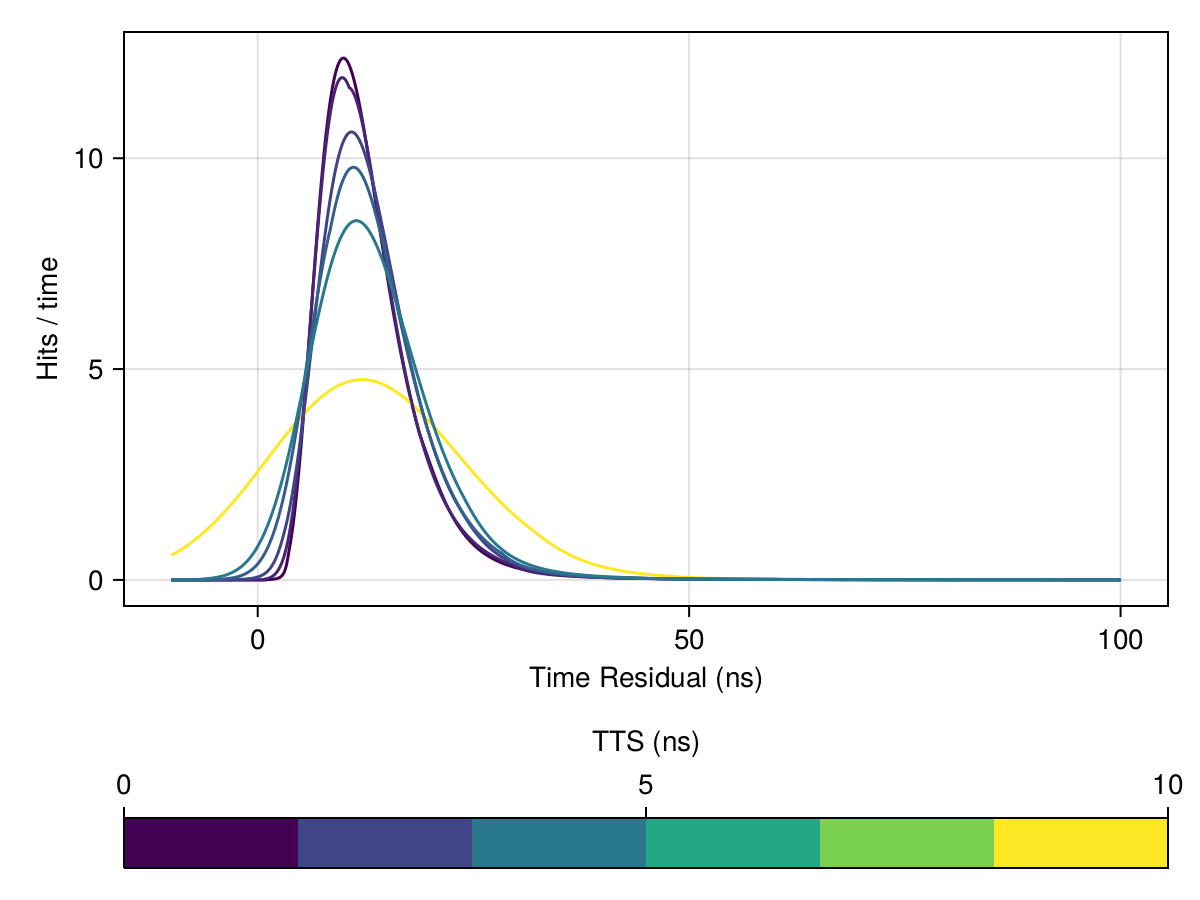

In [55]:

time_models = glob("time_uncert_*_2_FNL.bson", joinpath(workdir, "snakemake/time_surrogate_perturb/extended"))

rex = r"time_uncert_([0-9]+)_2_FNL.bson"
time_uncerts = [parse(Int64, match(rex, tm)[1]) for tm in time_models]


settings = NamedTuple[]
for (modelpath, var) in zip(time_models, time_uncerts)

    model = gpu(PhotonSurrogate(
        joinpath(workdir, "snakemake/time_surrogate_perturb/extended/amplitude_2_FNL.bson"),
        modelpath
    ))

    setting = (
        particle = Particle(particle_pos, particle_dir, 0.0, particle_energy, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 16,
        color_val = var
    )
    push!(settings, setting)
end

plot_pdf(settings, "TTS (ns)", time_uncerts)



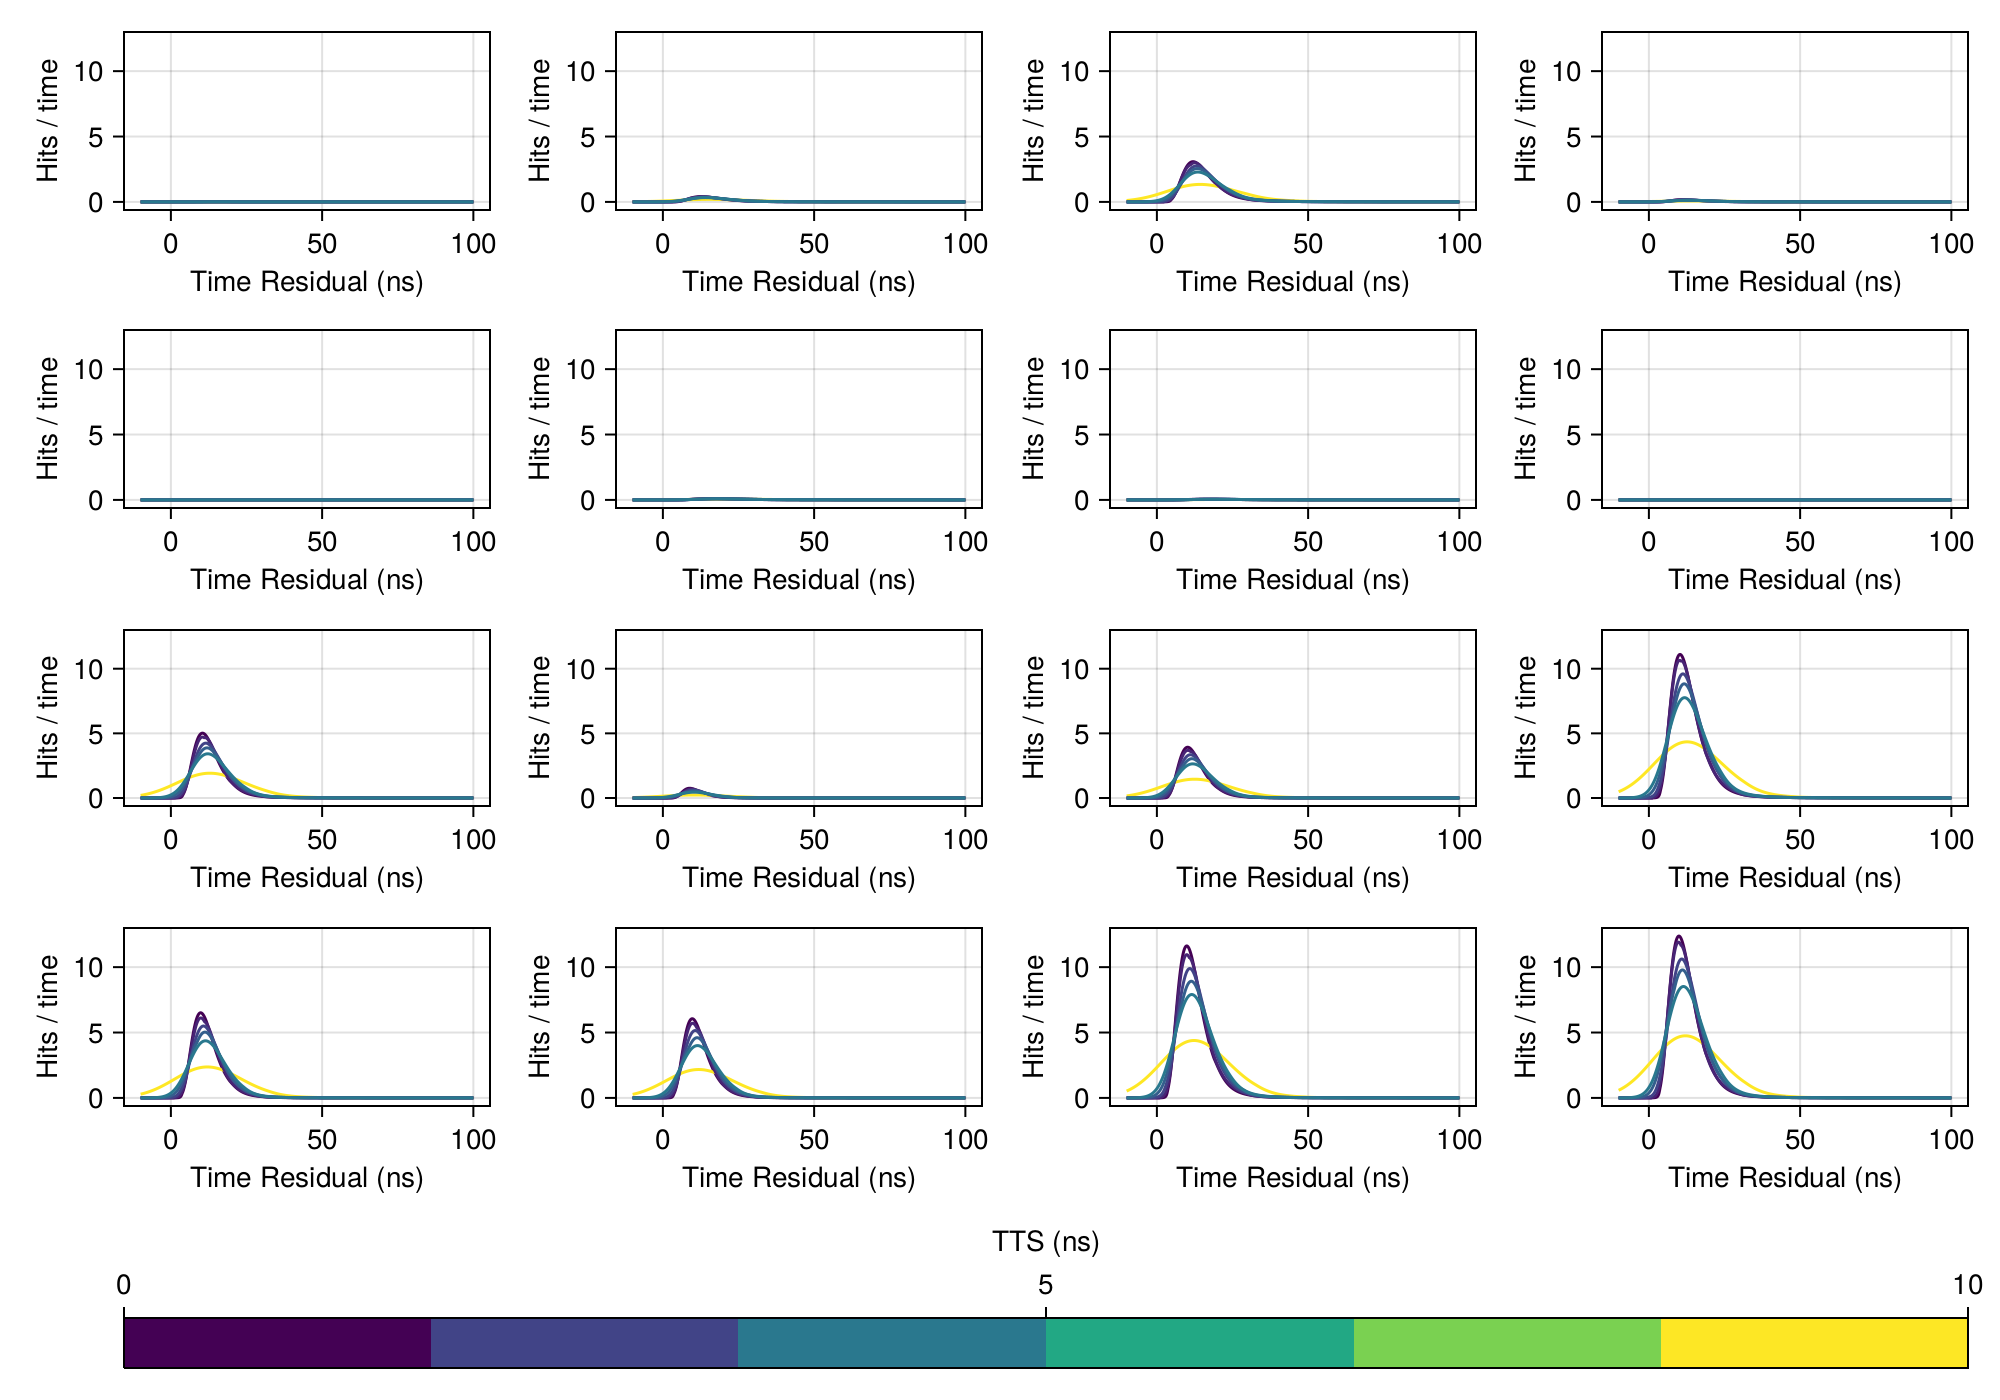

In [56]:
plot_pdf_grid(settings, "TTS (ns)", time_uncerts)

In [ ]:

time_models = glob("time_uncert_1_*_FNL.bson", joinpath(workdir, "snakemake/time_surrogate_perturb/extended"))
rex = r"time_uncert_*._([0-9]+)_FNL.bson"
model_ids = [parse(Int64, match(rex, tm)[1]) for tm in time_models]

settings = NamedTuple[]
for (modelpath, var) in zip(time_models, model_ids)

    model = gpu(PhotonSurrogate(
        joinpath(workdir, "snakemake/time_surrogate_perturb/extended/amplitude_2_FNL.bson"),
        modelpath
    ))

    setting = (
        particle = Particle(
            SA[-15.0, 0., 5.],
            sph_to_cart(0.7, 0.3), 0.0, 7e4, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 16,
        color_val = var
    )
    push!(settings, setting)
end


plot_pdf(settings, "Model ID", model_ids)
plot_pdf_grid(settings, "Model ID", model_ids)

amp_models = glob("amplitude_*_FNL.bson", joinpath(workdir, "snakemake/time_surrogate_perturb/extended"))
rex = r"amplitude_([0-9]+)_FNL.bson"
model_ids = [parse(Int64, match(rex, tm)[1]) for tm in amp_models]


settings = NamedTuple[]
for (modelpath, var) in zip(amp_models, model_ids)

    model = gpu(PhotonSurrogate(
        modelpath,
        joinpath(workdir, "snakemake/time_surrogate_perturb/extended/time_uncert_0_1_FNL.bson")
    ))

    setting = (
        particle = Particle(
            SA[-15.0, 0., 5.],
            sph_to_cart(0.7, 0.3), 0.0, 7e4, 0.0, PEMinus),
        target = target,
        abs_scale = 1.,
        sca_scale = 1.,
        model = model,
        pmt_ix = 16,
        color_val = var
    )
    push!(settings, setting)
end
plot_pdf(settings, "Model ID", model_ids)
plot_pdf_grid(settings, "Model ID", model_ids)
